In [2]:
import numpy as np
import dill
from copy import deepcopy
from pathlib import Path
import pandas as pd
from datetime import datetime
import itertools
from tqdm import tqdm
import numba as nb
import time
import read_data_functions as rdf
import model_helper_functions as mhf
from Optimal_Stopping_Object import ModelConstructor, ModelFitting
from initializer import InitialThangs
import loss_functions as lf
import constants


'''
This script can either do the warmstarts (set WARM_START = True)

It can also bootstrap using the best warmstart initial conditions
'''

# * Functions
def create_input_row_dict(model, loss, model_name,free_param_keys):
    input_row_dict = {"Model": model_name, 
                      "Loss": loss,
                      "fit_parameters":free_param_keys}
    input_row_dict.update(vars(model.inputs))
    input_row_dict.pop("timesteps")

    return input_row_dict

def create_results_row_dict(model,loss,model_name,free_param_keys):
    get_metric = model.results.get_metric
    model_data = [
        get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal'),
        get_metric(model.player_behavior.wtd_leave_time_sd,metric_type='true',decision_type='optimal'),
        get_metric(model.score_metrics.prob_indecision,metric_type='true',decision_type='optimal')*100,
        get_metric(model.score_metrics.prob_win,metric_type='true',decision_type='optimal')*100,
        get_metric(model.score_metrics.prob_incorrect,metric_type='true',decision_type='optimal')*100,
    ]
    results_row = {
        "Model":model_name,"Loss":loss,"fit_parameters":free_param_keys,
        "median_movement_onset_time":model_data[0],
        "sd_movement_onset_time":model_data[1],
        "indecisions":model_data[2],
        "wins":model_data[3],
        "incorrects":model_data[4],
    }
    return results_row
def get_base_model_loss(model, metric_keys, targets, decision_type="optimal"):
    # Get each metric from results at that specific decision time
    model_metrics = np.zeros_like(targets)
    for i in range(targets.shape[0]): 
        if 'leave_time' in metric_keys[i]:
            model_metric = getattr(model.player_behavior, metric_keys[i])
            # Find the metric at optimal decision time
            #! Metric type always being 'true' means that the metric array we're using is ALWAYS the 'true' array. 
            model_metrics[i,:] = model.results.get_metric(model_metric, 
                                                                decision_type=decision_type, 
                                                                metric_type="true")  
        elif 'decision_time' in metric_keys[i]:
            model_metric = getattr(model.results,metric_keys[i])
            model_metrics[i,:] = model_metric
        else:
            model_metric = getattr(model.score_metrics, metric_keys[i])
            model_metrics[i,:] = model.results.get_metric(model_metric, 
                                                                decision_type=decision_type, 
                                                                metric_type="true")  # Find the metric at optimal decision time
    loss = lf.ape_loss(model_metrics, targets,)
    return loss

#* GLOBAL PARAMETERS
# Select experiment you'd like to run
EXPERIMENT = "Exp1"
it = InitialThangs(EXPERIMENT)

#! SET THE SETTINGS BEFORE RUNNING SCRIPT
print("DID YOU SET THE RIGHT SETTINGS?")
FIT_PARAMETERS = True
SAVE = False
MODEL_TO_FIT = "suboptimal_all" # OPTIONS: "optimal", "suboptimal_partial", "suboptimal_none"
WARM_START = True # If False, that means I'm bootstrapping with the warmstart initial condition 
STORE_BASE_MODEL = True
input_keys = ["rt","rt_sd","mt","mt_sd","timing_sd",]
print(f" Fit Parameters: {FIT_PARAMETERS}\n Save: {SAVE}\n Model to Fit: {MODEL_TO_FIT}\n Warm Start: {WARM_START}\n Store Base Model: {STORE_BASE_MODEL}")
print(f" Fitting: {MODEL_TO_FIT}")
print(" ")
#* Load parameters, boostrap, and comparison targets
if True:
    #* True Parameters load
    with open(constants.MODEL_INPUT_PATH / 'model_input_dict.pkl','rb') as f:
        model_input_dict = dill.load(f)
    true_parameters = [np.nanmedian(v) for k,v in model_input_dict.items() if "agent" not in k] 
    #* Bootstrap Load
    with open(constants.MODEL_INPUT_PATH / 'bootstrap_parameter_distribution.pkl','rb') as f:
        parameter_distribution = dill.load(f)    
    with open(constants.MODEL_INPUT_PATH / 'bootstrap_results.pkl','rb') as f:
        results = dill.load(f)    
    with open(constants.MODEL_INPUT_PATH / 'participant_ids.pkl','rb') as f:
        participant_ids = dill.load(f)        
    #* Comparison Targets load
    with open(constants.MODEL_INPUT_PATH / 'participant_median_movement_onset_time.pkl','rb') as f:
        participant_median_movement_onset_time = dill.load(f)
    with open(constants.MODEL_INPUT_PATH / 'participant_sd_movement_onset_time.pkl','rb') as f:
        participant_sd_movement_onset_time = dill.load(f)
    with open(constants.MODEL_INPUT_PATH / 'participant_wins.pkl','rb') as f:
        participant_wins = dill.load(f)  
    with open(constants.MODEL_INPUT_PATH / 'participant_incorrects.pkl','rb') as f:
        participant_incorrects = dill.load(f)  
    with open(constants.MODEL_INPUT_PATH / 'participant_indecisions.pkl','rb') as f:
        participant_indecisions = dill.load(f)  
 
#* Run warm_start or boostrap using warmstart 
if WARM_START:
    print("FINDING INITIAL CONDITIONS")
    iters = 10000
    #* Randomize for warmstart
    player_inputs = dict(zip(input_keys,true_parameters)) #! This won't change unless we're boostrapping so can pull out of for loop for Warm_Start
    switch_delay_expected_rand = np.random.uniform(0,200,size=iters)
    switch_delay_true_rand = np.random.uniform(0,200,size=iters)
    switch_sd_expected_rand = np.random.uniform(0,200,size=iters)
    switch_sd_true_rand = np.random.uniform(0,200,size=iters)
    # timing_sd_expected_rand = np.random.uniform(0,np.max(player_inputs['timing_sd']),size=iters)
else:
    print("BOOTSTRAPPING MODEL FITS USING WARMSTART")
    path = constants.MODELS_PATH / "warmstart_models"
    df_results = list(path.glob(f"{EXPERIMENT}_{MODEL_TO_FIT}_warmstart_results*"))[-1]
    df_inputs = list(path.glob(f"{EXPERIMENT}_{MODEL_TO_FIT}_warmstart_inputs*"))[-1]
    df_warmstart_results = pd.read_pickle(path / df_results)
    df_warmstart_inputs = pd.read_pickle(path / df_inputs)
    best_warmstart_inputs = df_warmstart_inputs[df_warmstart_inputs["Loss"] == df_warmstart_inputs["Loss"].min()].iloc[0]
    iters = participant_ids.shape[0]

print(f"ITERATIONS: {iters}")

initial_time = time.time()
base_input_parameters_for_df = []
base_results_for_df = []
input_parameters_for_df = []
results_for_df = []
print("Starting Models...")
for i in tqdm(range(iters)):
    if WARM_START:        
        # Optimal/Suboptimal handles the initial guess to free params mapping
        initial_guess = {
            "guess_switch_delay_true": switch_delay_true_rand[i],
            "guess_switch_delay_expected": switch_delay_expected_rand[i],
            "guess_switch_sd_true": switch_sd_true_rand[i],
            "guess_switch_sd_expected": switch_sd_expected_rand[i],
            # "timing_sd_expected": timing_sd_expected_rand[i]
        }
    else: 
        # Player inputs are bootstrapped
        player_inputs = dict(zip(input_keys,parameter_distribution[i,:]))
        
        # Use initial guess dict from warmstart
        initial_guess = {
            "guess_switch_delay_true": best_warmstart_inputs["guess_switch_delay"].squeeze()[0],
            "guess_switch_delay_expected": best_warmstart_inputs["guess_switch_delay"].squeeze()[1],
            "guess_switch_sd_true": best_warmstart_inputs["guess_switch_sd"].squeeze()[0],
            "guess_switch_sd_expected": best_warmstart_inputs["guess_switch_sd"].squeeze()[1],
            # "timing_sd_expected": best_warmstart_inputs["timing_sd"].squeeze()[1,0]
        }
    model_name = f"model{i}_{datetime.now():%Y_%m_%d_%H_%M_%S}"

    #* 3 Models 
    #* 1. Full optimal, no fitting, no switch delay or uncertainty
    #* 2. Full optimal, accounting for fit switch delay and uncertainty, and the expected and true have to be equal
    #* 3. Full optimal, not accounting for fit switch delay and uncertainty, and the expected and true are both fit simultaneously
    
    # Run pure optimal, no switch 
    optimal_model_no_switch = mhf.run_model(player_inputs,
                                            expected=False,use_agent_behavior_lookup=False,
                                            round_num=20)

    # Run either optimal or suboptimal    
    if MODEL_TO_FIT == "optimal":
        fit_model = mhf.run_model(player_inputs,
                                  expected=False,use_agent_behavior_lookup=False,
                                  round_num=20)
        #! Not putting _true or _expected makes true == expected
        free_params = {
            "guess_switch_delay": initial_guess['guess_switch_delay_true'],
            "guess_switch_sd": initial_guess['guess_switch_sd_true'],
            }
        assert fit_model.inputs.expected == False
    elif MODEL_TO_FIT == "suboptimal_partial":
        fit_model = mhf.run_model(player_inputs,
                                  expected=True,use_agent_behavior_lookup=False,
                                  round_num=20,)
        assert fit_model.inputs.expected == True
        #* Fit the true and expected separately and see what the model does
        free_params = {
            "guess_switch_delay_true": initial_guess['guess_switch_delay_true'],
            "guess_switch_delay_expected": initial_guess['guess_switch_delay_expected'],
            "guess_switch_sd_true": initial_guess['guess_switch_sd_true'],
            "guess_switch_sd_expected": initial_guess['guess_switch_sd_expected'],
        }
    elif MODEL_TO_FIT == "suboptimal_none":
        #! 12/4/23 - Also want to just fit the true and holding the expected at zero
        # Switch delay and sd are automatically set to zero in the run_model function 
        fit_model = mhf.run_model(player_inputs,
                                  expected=True,use_agent_behavior_lookup=False,
                                  round_num=20,)
        free_params = {
            "guess_switch_delay_true": initial_guess['guess_switch_delay_true'],
            "guess_switch_sd_true": initial_guess['guess_switch_sd_true'],
        }
    elif MODEL_TO_FIT == "suboptimal_all":
        # Switch delay and sd are automatically set to zero in the run_model function 
        fit_model = mhf.run_model(player_inputs,
                                  expected=True,use_agent_behavior_lookup=False,
                                  round_num=20,)
        free_params = {
            "guess_switch_delay_true": initial_guess['guess_switch_delay_true'],
            "guess_switch_delay_expected": initial_guess['guess_switch_delay_expected'],
            "guess_switch_sd_true": initial_guess['guess_switch_sd_true'],
            "guess_switch_sd_expected": initial_guess['guess_switch_sd_expected'],
            "timing_sd_expected": player_inputs['timing_sd'],
            "reaction_time_expected":player_inputs["rt"],
            "reaction_sd_expected":player_inputs["rt_sd"],
            "movement_time_expected":player_inputs["mt"],
            "movement_sd_expected":player_inputs["mt_sd"],
            "electromechanical_delay_expected":50,
            "electromechanical_sd_expected":10,
        }
        
    assert fit_model.inputs.round_num == 20
    
    #! Need to be in for loop because we're using specific participant_ids if not warmstart
    if WARM_START:
        comparison_targets = np.array(
            [
                np.nanmedian(participant_median_movement_onset_time, axis=0),
                np.nanmedian(participant_sd_movement_onset_time, axis=0),
                np.nanmedian(participant_wins,axis=0)/it.num_trials,
                np.nanmedian(participant_incorrects,axis=0)/it.num_trials,
                np.nanmedian(participant_indecisions,axis=0)/it.num_trials,
            ]   
        )
    else:
        comparison_targets = np.array(
            [
                np.nanmedian(participant_median_movement_onset_time[participant_ids[i,:]], axis=0),
                np.nanmedian(participant_sd_movement_onset_time[participant_ids[i,:]], axis=0),
                np.nanmedian(participant_wins[participant_ids[i,:]],axis=0)/it.num_trials,
                np.nanmedian(participant_incorrects[participant_ids[i,:]],axis=0)/it.num_trials,
                np.nanmedian(participant_indecisions[participant_ids[i,:]],axis=0)/it.num_trials,
            ]   
        )      
    model_metric_keys = ['wtd_leave_time','wtd_leave_time_sd','prob_win','prob_incorrect','prob_indecision']
    model_fit_object = ModelFitting(model=fit_model)
    # start_time = time.time()
    res = model_fit_object.run_model_fit_procedure(
        free_params_init=free_params,
        targets=comparison_targets,
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=model_metric_keys,
        bnds=None,
        xtol=1e-6,
        ftol =1e-6,
        method="Powell",
        maxiter=5,
        maxfev = 300,
    )
    specific_model_name = MODEL_TO_FIT + "_" + model_name
    loss = model_fit_object.loss_store[-1]
    input_row_dict = create_input_row_dict(fit_model, loss, specific_model_name,list(free_params.keys()))
    input_parameters_for_df.append(input_row_dict)
    results_dict   = create_results_row_dict(fit_model,loss,specific_model_name,list(free_params.keys()))
    results_for_df.append(results_dict)
    if not WARM_START and STORE_BASE_MODEL:
        base_model_name = "base_" + model_name
        # base_model_fit_object = ModelFitting(model=optimal_model_no_switch)
        base_model_loss = get_base_model_loss(optimal_model_no_switch, model_metric_keys, comparison_targets)
        base_input_row_dict = create_input_row_dict(optimal_model_no_switch, base_model_loss, base_model_name, [])
        base_input_parameters_for_df.append(base_input_row_dict)
        base_results_dict   = create_results_row_dict(optimal_model_no_switch,base_model_loss,base_model_name,[])
        base_results_for_df.append(base_results_dict)
    break    
df_inputs = pd.DataFrame(input_parameters_for_df)
df_results = pd.DataFrame(results_for_df)

if SAVE:
    save_date = datetime.now()
    if WARM_START:
        n = "warmstart"
    else:
        n = "bootstrapped"
        #* Save base model if we aren't warmstarting and if we want to
        if STORE_BASE_MODEL:
            df_base_inputs = pd.DataFrame(base_input_parameters_for_df)
            df_base_results = pd.DataFrame(base_results_for_df)
            with open(constants.MODELS_PATH / f"{n}_models" / f"{EXPERIMENT}_base_bootstrapped_inputs_{save_date:%Y_%m_%d_%H_%M_%S}.pkl", "wb") as f:
                dill.dump(df_base_inputs, f)
            with open(constants.MODELS_PATH / f"{n}_models" / f"{EXPERIMENT}_base_bootstrapped_results_{save_date:%Y_%m_%d_%H_%M_%S}.pkl", "wb") as f:
                dill.dump(df_base_results, f)
                
    #* Save either warmstart or bootstrapped
    with open(constants.MODELS_PATH / f"{n}_models" / f"{EXPERIMENT}_{MODEL_TO_FIT}_{n}_inputs_{save_date:%Y_%m_%d_%H_%M_%S}.pkl", "wb") as f:
        dill.dump(df_inputs, f)
    with open(constants.MODELS_PATH / f"{n}_models" / f"{EXPERIMENT}_{MODEL_TO_FIT}_{n}_results_{save_date:%Y_%m_%d_%H_%M_%S}.pkl", "wb") as f:
        dill.dump(df_results, f)
    
        
finish_time = time.time()
total_time = finish_time - initial_time
print(f"Model generation for {EXPERIMENT} completed")
print(f"Total Runtime for {iters} iterations: {total_time}")

DID YOU SET THE RIGHT SETTINGS?
 Fit Parameters: True
 Save: False
 Model to Fit: suboptimal_all
 Warm Start: True
 Store Base Model: True
 Fitting: suboptimal_all
 
FINDING INITIAL CONDITIONS
ITERATIONS: 10000
Starting Models...


  0%|          | 0/10000 [00:54<?, ?it/s]

Model generation for Exp1 completed
Total Runtime for 10000 iterations: 54.12123513221741


In [5]:
from initializer import InitialThangs
import plot_functions as pf
import constants
import model_helper_functions as mhf
import data_visualization as dv
import matplotlib.pyplot as plt

wheel = dv.ColorWheel()
it = InitialThangs(experiment="Exp1")
%load_ext autoreload
%autoreload 2
plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')
# #* True Parameters load
# with open(constants.MODEL_INPUT_PATH / 'model_input_dict.pkl','rb') as f:
#     model_input_dict = dill.load(f)
# true_parameters = [np.nanmedian(v) for k,v in model_input_dict.items() if "agent" not in k] 
# #* Bootstrap Load
with open(constants.MODEL_INPUT_PATH / 'bootstrap_parameter_distribution.pkl','rb') as f:
    parameter_distribution = dill.load(f)    
# with open(constants.MODEL_INPUT_PATH / 'bootstrap_results.pkl','rb') as f:
#     results = dill.load(f)    
# with open(constants.MODEL_INPUT_PATH / 'participant_ids.pkl','rb') as f:
#     participant_ids = dill.load(f)        
#* Comparison Targets load
with open(constants.MODEL_INPUT_PATH / 'participant_median_movement_onset_time.pkl','rb') as f:
    participant_median_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_sd_movement_onset_time.pkl','rb') as f:
    participant_sd_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_wins.pkl','rb') as f:
    participant_wins = dill.load(f)  
participant_perc_wins = (participant_wins/it.num_trials)*100
with open(constants.MODEL_INPUT_PATH / 'participant_incorrects.pkl','rb') as f:
    participant_incorrects = dill.load(f)  
participant_perc_incorrects = (participant_incorrects/it.num_trials)*100

with open(constants.MODEL_INPUT_PATH / 'participant_indecisions.pkl','rb') as f:
    participant_indecisions = dill.load(f)  
participant_perc_indecisions = (participant_indecisions/it.num_trials)*100

In [6]:
df_inputs

,Model,Loss,fit_parameters,experiment,num_blocks,agent_means,agent_sds,nsteps,num_timesteps,round_num,...,reaction_time,movement_time,guess_switch_delay,electromechanical_delay,guess_delay,win_reward,incorrect_cost,indecision_cost,prob_selecting_correct_target_reaction,prob_selecting_correct_target_guess
0,suboptimal_all_model0_2023_12_06_15_38_00,0.419913,"[guess_switch_delay_true, guess_switch_delay_e...",Exp1,6,"[[[1000.0], [1000.0], [1100.0], [1100.0], [120...","[[[50.0], [150.0], [50.0], [150.0], [50.0], [1...",1,1800,20,...,"[[[241.25]], [[243.53436530359886]]]","[[[151.0]], [[152.000129076118]]]","[[[19.32404703838769]], [[2.734462489752149]]]","[[[50.0]], [[55.2351617920057]]]","[[[69.32404703838769]], [[57.969624281757845]]]",1.0,0.0,0.0,1.0,0.5


In [7]:
df_results

,Model,Loss,fit_parameters,median_movement_onset_time,sd_movement_onset_time,indecisions,wins,incorrects
0,suboptimal_all_model0_2023_12_06_15_38_00,0.419913,"[guess_switch_delay_true, guess_switch_delay_e...","[1221.2078185984103, 1171.9676815523705, 1248....","[72.45028212442737, 126.01725600474153, 95.785...","[7.53649875499457, 13.500599795303902, 22.9662...","[85.0058509439977, 73.25138158753843, 55.08021...","[7.457650301007725, 13.248018617157664, 21.953..."


# Plots

## Parameter Bar Plots

(2,)
(2,)
(2,)
(2,)
(2, 6)
(2,)
(2,)
(2,)
(2,)


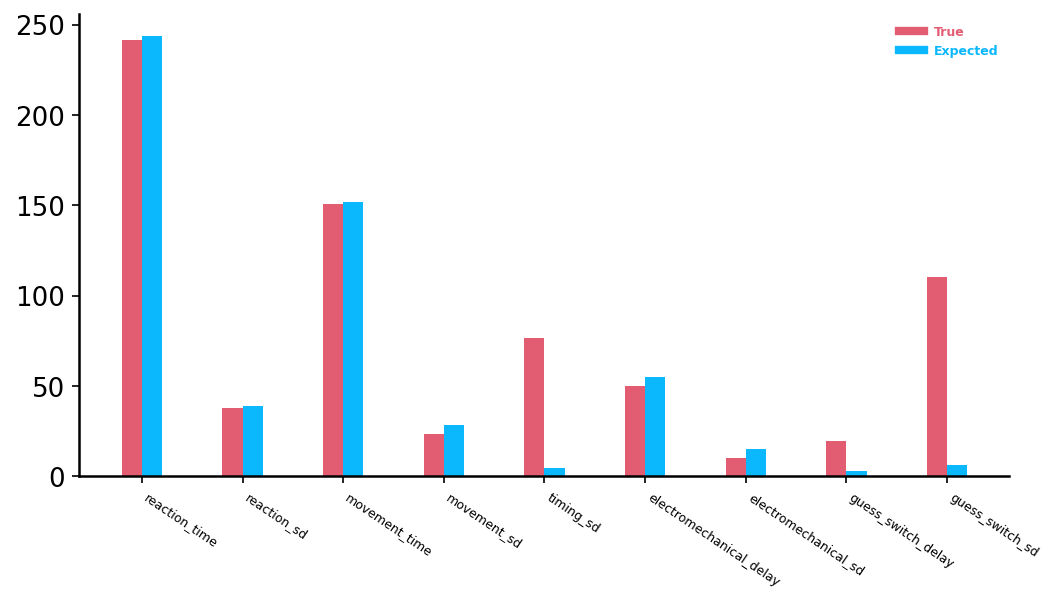

In [53]:
from scipy.ndimage import rotate


parameter_columns = ["reaction_time", "reaction_sd",
                     "movement_time","movement_sd",
                     "timing_sd",
                     "electromechanical_delay", "electromechanical_sd",
                     "guess_switch_delay", "guess_switch_sd"]
fig,ax = plt.subplots(dpi=150,figsize=(8,4))
barwidth = 0.2
xlocs = np.arange(0, len(parameter_columns))
for i,col_name in enumerate(parameter_columns):
    col = np.stack(df_inputs[col_name].to_numpy()).squeeze()
    print(col.shape)
    if col.ndim>1:
        col = col[:,0]
    ax.bar([xlocs[i]-barwidth/2,xlocs[i]+barwidth/2], col, width=barwidth, color=[wheel.rak_red, wheel.rak_blue])
ax.set_xticks(xlocs, labels=parameter_columns, fontsize=6,rotation=-34, ha = 'left')
dv.legend(ax, labels=["True", "Expected"], colors=[wheel.rak_red,wheel.rak_blue])
plt.show()


In [9]:
col_names = ["median_movement_onset_time", "sd_movement_onset_time",
              "wins", "incorrects","indecisions",]
optimal_medians = {}
optimal_intervals = {}
for i,col_name in enumerate(col_names):
    arr = np.stack(df_results[col_name].to_numpy())
    optimal_medians.update({col_name:np.median(arr,axis=0)[[0,2,4,1,3,5]]})
    optimal_intervals.update({col_name:np.percentile(arr,[5,95],axis=0)[:,[0,2,4,1,3,5]]})    

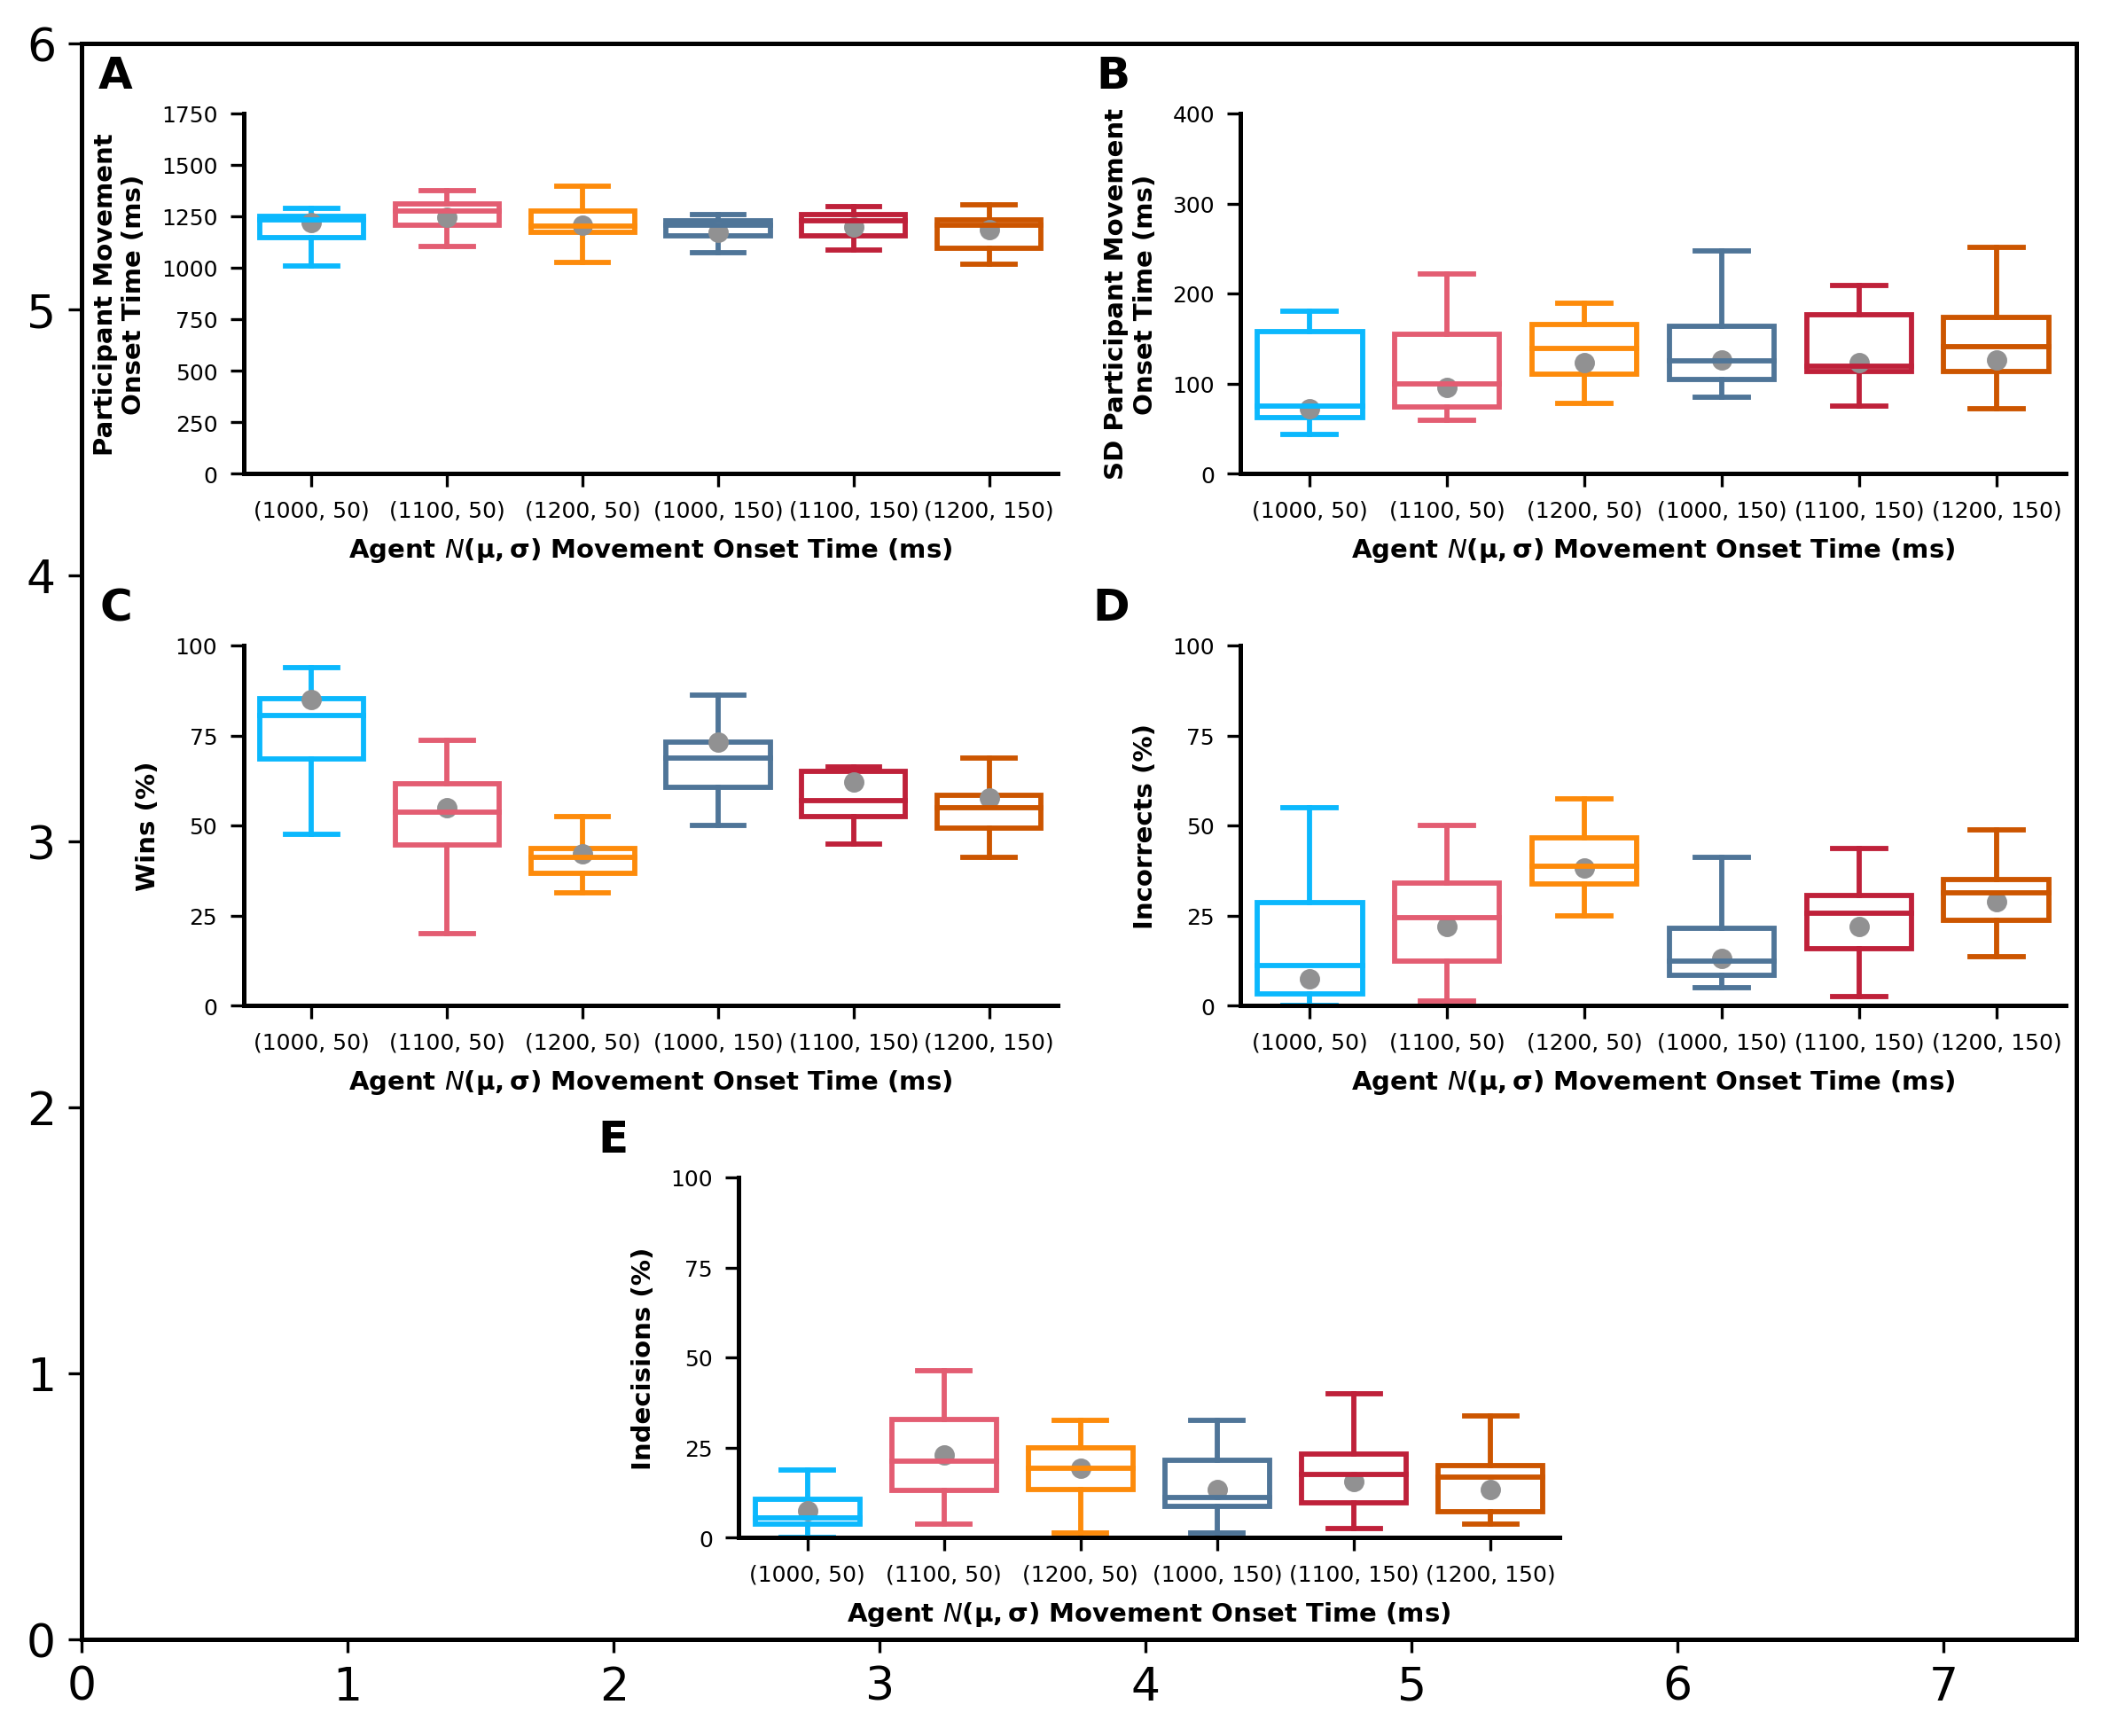

In [12]:
save_path = Path(
    r"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures"
)
w, h = 7.5, 6
bw = (
    0.35 * w
) / it.num_blocks  # box widths of all boxes combined takes up 30% of the width
mult_w, div_w = 0.053, 2.3
div_h = 1.75
xlocs = np.linspace(0, w / div_w, num=len(it.trial_block_titles))
legend_fontsize = 5
ticklabel_fontsize = 6
suptitle_fontsize = 6
label_fontsize = 7
markersize = 0.1*(w*h)

metrics = np.array(
    [
        participant_median_movement_onset_time,
        participant_sd_movement_onset_time,
        participant_perc_wins,
        participant_perc_incorrects,
        participant_perc_indecisions,
    ]
)[
    :, :, [0, 2, 4, 1, 3, 5]
]  # Rearranging axes to get the order I want
ylocs = (
    [np.arange(0, 1751, 250)] + [np.arange(0, 401, 100)] + [np.arange(0, 101, 25)] * 3
)
ylabels = [
    "Participant Movement\nOnset Time (ms)",
    "SD Participant Movement\nOnset Time (ms)",
    "Wins (%)",
    "Incorrects (%)",
    "Indecisions (%)",
]
ylims = [(0, 1750)] + [(0, 400)] + [(0, 100)] * 3

model_labels = ["Base Model", "Optimal Model", "Suboptimal Model"]
# save_names = ["exp1_results_only_optimal_model", 'exp1_results_both_models','exp1_results_statistics',]
suptitles = ["Model Results", "Model Results", "Participant Behaviour"]
legend_locs = (0.58, 0.86)
median_dicts = [optimal_medians]
interval_dicts = [optimal_intervals]

mosaic = "aabb;ccdd;.ee."
fig = pf.NewFigure(mosaic, dpi=300, figsize=(w, h),wspace=None, hspace=None)
axs = list(fig.axes.values())
model_colors = [wheel.grey, wheel.dark_grey, wheel.black]
# * Looping axes for each metric
for i, (ax, col_name) in enumerate(zip(axs, col_names)):
    # * Looping each experimental condition
    for j in range(len(xlocs)):
        dv.boxplot(
            ax,
            xlocs[j],
            metrics[i, :, j],
            color=constants.xticklabel_colors_means[j],
            data_color=constants.xticklabel_colors_means[j],
            box_lw=1.4
        )
        for k, (model_medians, model_intervals) in enumerate(
            zip(median_dicts, interval_dicts)
        ):
            pf.plot_boostrapped_model_results(
                ax,
                xlocs[j],
                y=model_medians[col_name][j],
                percentiles=model_intervals[col_name][:, j],
                horizontal_lw=0,
                markersize=markersize,
                color=model_colors[k],
            )

    # dv.jitter_array(ax=ax,x_positions=xlocs,data=metrics[i,:,:].T,
    #                 data_color = constants.xticklabel_colors_means,
    #                 data_edge_color = wheel.lighten_color(wheel.light_grey,1.2),
    #                 noise_scale=0.06, include_mean = False, circle_size=40)

    ax.set_ylim(ylims[i])
    ax.set_xlim(min(xlocs) - 0.75*bw, max(xlocs) + 0.75*bw)
    ax.set_xticks(xlocs, labels=constants.xticklabels, fontsize=ticklabel_fontsize)
    ax.set_yticks(ylocs[i], labels=ylocs[i], fontsize=ticklabel_fontsize)
    ax.set_xlabel(it.xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabels[i], fontsize=label_fontsize)
    # dv.legend(ax, labels=model_labels, colors=model_colors,fontsize=legend_fontsize)
    # [ticklabel.set_color(color) for (color,ticklabel) in zip(constants.xticklabel_colors_means,ax.xaxis.get_ticklabels())]

fig.add_all_letters()
fig.fig.facecolor = 1
# fig.pad_fig(w_pad=-2,h_pad=0,w_space=-2,h_space=0.1)
for ax_label in ["a","b","c", "d"]:
    if ax_label in ["b","d"]:
        fig.adjust_position(fig.axes[ax_label], (-0.1, 0))
    fig.adjust_size(fig.axes[ax_label], (0.1, 0))
# plt.subplots_adjust(right=0.8)
# plt.subplot_tool()
plt.show()
# fig.savefig(SAVE_PATH / "test.png")